In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-01 22:36:41.996248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 22:36:42.000699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 22:36:42.001033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-01 22:36:42.278377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 22:36:42.279179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 22:36:42.279549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 22:36:42.279852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [2.9000589e-01, 0.0000000e+00, 2.6115039e-01],
         [0.0000000e+00, 0.0000000e+00, 1.2355357e+00],
         ...,
         [1.2697663e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 3.6595325e+00, 5.1262274e+00],
         [0.0000000e+00, 2.2648537e+00, 2.6140008e+00]],

        [[0.0000000e+00, 0.0000000e+00, 1.4276376e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [1.9630570e+00, 0.0000000e+00, 1.7145691e+00],
         ...,
         [1.1862108e+00, 2.2146894e-01, 0.0000000e+00],
         [3.3393061e+00, 3.9263823e+00, 4.8196402e-01],
         [4.8130155e+00, 1.4175080e+00, 1.2355119e+00]],

        [[5.9818363e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 1.4010913e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],


In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [2.9000589e-01, 0.0000000e+00, 2.6115039e-01],
          [0.0000000e+00, 0.0000000e+00, 1.2355357e+00],
          ...,
          [1.2697663e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 3.6595325e+00, 5.1262274e+00],
          [0.0000000e+00, 2.2648537e+00, 2.6140008e+00]],
 
         [[0.0000000e+00, 0.0000000e+00, 1.4276376e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [1.9630570e+00, 0.0000000e+00, 1.7145691e+00],
          ...,
          [1.1862108e+00, 2.2146894e-01, 0.0000000e+00],
          [3.3393061e+00, 3.9263823e+00, 4.8196402e-01],
          [4.8130155e+00, 1.4175080e+00, 1.2355119e+00]],
 
         [[5.9818363e-01, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 1.4010913e+00],
          ...,
          [0.0000000e+00, 

<IPython.core.display.Javascript object>


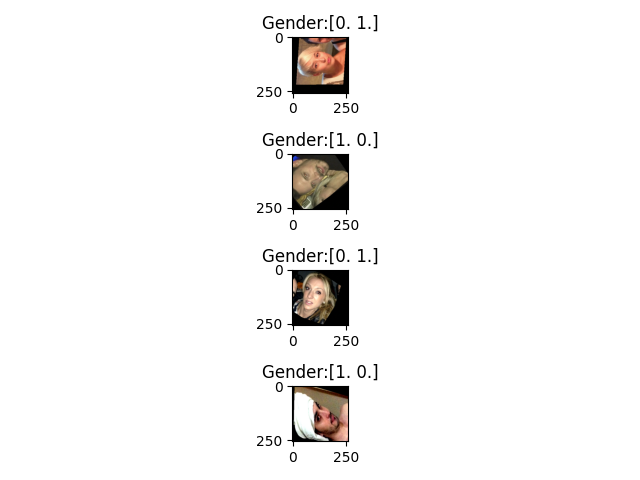

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_5')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 32

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 32)           870752      ['tf.math.subtract[0][0]']    

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_5"
logPrefix = "log"

In [42]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-01 22:37:43.117188: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-01 22:37:43.117206: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-01 22:37:43.117227: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-01 22:37:43.490529: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-01 22:37:43.491847: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


3528/3528 [==============================] - 14s 4ms/step - loss: 7723.2139 - gender_out_loss: 0.6930 - tf.math.multiply_1_loss: 5990.7969 - gender_out_accuracy: 0.5237
Epoch 1/300
   1/1000 [..............................] - ETA: 14:17 - loss: 10851.7344 - gender_out_loss: 0.6988 - tf.math.multiply_1_loss: 9104.8096 - gender_out_accuracy: 0.5000

2022-11-01 22:37:58.000921: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-01 22:37:58.001067: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   8/1000 [..............................] - ETA: 49s - loss: 8454.9844 - gender_out_loss: 0.6961 - tf.math.multiply_1_loss: 6714.6333 - gender_out_accuracy: 0.4375  

2022-11-01 22:37:58.340604: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-01 22:37:58.341645: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-01 22:37:58.375371: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3170 callback api events and 3129 activity events. 
2022-11-01 22:37:58.403094: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-01 22:37:58.439917: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_5/log_0/plugins/profile/2022_11_01_22_37_58

2022-11-01 22:37:58.490771: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_5/log_0/plugins/profile/2022_11_01_22_37_58/rachanon-pc1.trace.json.gz
2022-11-01 22:37:58.531882: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/A

1000/1000 [==============================] - 22s 21ms/step - loss: 6919.3374 - gender_out_loss: 0.7156 - tf.math.multiply_1_loss: 5130.3687 - gender_out_accuracy: 0.5197 - val_loss: 5560.5420 - val_gender_out_loss: 0.6906 - val_tf.math.multiply_1_loss: 3834.1194 - val_gender_out_accuracy: 0.5243
Epoch 2/300
1000/1000 [==============================] - 21s 21ms/step - loss: 5106.9097 - gender_out_loss: 0.6933 - tf.math.multiply_1_loss: 3373.6375 - gender_out_accuracy: 0.5497 - val_loss: 4989.7451 - val_gender_out_loss: 0.6882 - val_tf.math.multiply_1_loss: 3269.1301 - val_gender_out_accuracy: 0.5377
Epoch 3/300
1000/1000 [==============================] - 21s 21ms/step - loss: 4521.9146 - gender_out_loss: 0.6777 - tf.math.multiply_1_loss: 2827.7544 - gender_out_accuracy: 0.5625 - val_loss: 4742.3677 - val_gender_out_loss: 0.6911 - val_tf.math.multiply_1_loss: 3014.5178 - val_gender_out_accuracy: 0.5333
Epoch 4/300
1000/1000 [==============================] - 21s 21ms/step - loss: 4389.2

1000/1000 [==============================] - 21s 21ms/step - loss: 3029.1499 - gender_out_loss: 0.6543 - tf.math.multiply_1_loss: 1393.4492 - gender_out_accuracy: 0.6112 - val_loss: 3576.6628 - val_gender_out_loss: 0.7680 - val_tf.math.multiply_1_loss: 1656.7018 - val_gender_out_accuracy: 0.5277
Epoch 28/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3173.1072 - gender_out_loss: 0.6844 - tf.math.multiply_1_loss: 1462.0823 - gender_out_accuracy: 0.5577 - val_loss: 3347.2466 - val_gender_out_loss: 0.6833 - val_tf.math.multiply_1_loss: 1639.0447 - val_gender_out_accuracy: 0.5538
Epoch 29/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3104.8850 - gender_out_loss: 0.6791 - tf.math.multiply_1_loss: 1407.1539 - gender_out_accuracy: 0.5755 - val_loss: 3303.6677 - val_gender_out_loss: 0.6776 - val_tf.math.multiply_1_loss: 1609.6752 - val_gender_out_accuracy: 0.5855
Epoch 30/300
1000/1000 [==============================] - 21s 21ms/step - loss: 309

1000/1000 [==============================] - 21s 21ms/step - loss: 3025.7803 - gender_out_loss: 0.6794 - tf.math.multiply_1_loss: 1327.3396 - gender_out_accuracy: 0.5753 - val_loss: 3246.3267 - val_gender_out_loss: 0.6809 - val_tf.math.multiply_1_loss: 1544.1320 - val_gender_out_accuracy: 0.5652
Epoch 54/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2992.6936 - gender_out_loss: 0.6855 - tf.math.multiply_1_loss: 1279.0485 - gender_out_accuracy: 0.5608 - val_loss: 3316.8672 - val_gender_out_loss: 0.7073 - val_tf.math.multiply_1_loss: 1548.5620 - val_gender_out_accuracy: 0.4812
Epoch 55/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3003.2559 - gender_out_loss: 0.6791 - tf.math.multiply_1_loss: 1305.5458 - gender_out_accuracy: 0.5822 - val_loss: 3204.1187 - val_gender_out_loss: 0.6760 - val_tf.math.multiply_1_loss: 1514.1698 - val_gender_out_accuracy: 0.5818
Epoch 56/300
1000/1000 [==============================] - 21s 21ms/step - loss: 295

1000/1000 [==============================] - 21s 21ms/step - loss: 2940.2175 - gender_out_loss: 0.6873 - tf.math.multiply_1_loss: 1222.0515 - gender_out_accuracy: 0.5458 - val_loss: 3195.2451 - val_gender_out_loss: 0.6789 - val_tf.math.multiply_1_loss: 1497.8693 - val_gender_out_accuracy: 0.5678
Epoch 80/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2859.8525 - gender_out_loss: 0.6491 - tf.math.multiply_1_loss: 1237.0802 - gender_out_accuracy: 0.6258 - val_loss: 3212.1443 - val_gender_out_loss: 0.6789 - val_tf.math.multiply_1_loss: 1514.9130 - val_gender_out_accuracy: 0.5680
Epoch 81/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3001.4587 - gender_out_loss: 0.6777 - tf.math.multiply_1_loss: 1307.1653 - gender_out_accuracy: 0.5795 - val_loss: 3203.0056 - val_gender_out_loss: 0.6841 - val_tf.math.multiply_1_loss: 1492.7526 - val_gender_out_accuracy: 0.5567
Epoch 82/300
1000/1000 [==============================] - 21s 21ms/step - loss: 299

1000/1000 [==============================] - 21s 21ms/step - loss: 2884.8896 - gender_out_loss: 0.6522 - tf.math.multiply_1_loss: 1254.4089 - gender_out_accuracy: 0.6192 - val_loss: 3152.1587 - val_gender_out_loss: 0.6725 - val_tf.math.multiply_1_loss: 1470.9690 - val_gender_out_accuracy: 0.5830
Epoch 106/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2910.7473 - gender_out_loss: 0.6729 - tf.math.multiply_1_loss: 1228.4368 - gender_out_accuracy: 0.5882 - val_loss: 3266.6250 - val_gender_out_loss: 0.7126 - val_tf.math.multiply_1_loss: 1485.1454 - val_gender_out_accuracy: 0.4854
Epoch 107/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2931.4971 - gender_out_loss: 0.6791 - tf.math.multiply_1_loss: 1233.8292 - gender_out_accuracy: 0.5750 - val_loss: 3160.7129 - val_gender_out_loss: 0.6719 - val_tf.math.multiply_1_loss: 1480.9740 - val_gender_out_accuracy: 0.5868
Epoch 108/300
1000/1000 [==============================] - 21s 21ms/step - loss: 

1000/1000 [==============================] - 20s 21ms/step - loss: 2911.9302 - gender_out_loss: 0.6573 - tf.math.multiply_1_loss: 1268.7009 - gender_out_accuracy: 0.6173 - val_loss: 3149.6733 - val_gender_out_loss: 0.6687 - val_tf.math.multiply_1_loss: 1477.9976 - val_gender_out_accuracy: 0.5834
Epoch 132/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2858.6396 - gender_out_loss: 0.6757 - tf.math.multiply_1_loss: 1169.4763 - gender_out_accuracy: 0.5745 - val_loss: 3119.4058 - val_gender_out_loss: 0.6624 - val_tf.math.multiply_1_loss: 1463.4790 - val_gender_out_accuracy: 0.6050
Epoch 133/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2781.1077 - gender_out_loss: 0.6390 - tf.math.multiply_1_loss: 1183.6667 - gender_out_accuracy: 0.6463 - val_loss: 3175.1780 - val_gender_out_loss: 0.6803 - val_tf.math.multiply_1_loss: 1474.4471 - val_gender_out_accuracy: 0.5717
Epoch 134/300
1000/1000 [==============================] - 21s 21ms/step - loss: 

1000/1000 [==============================] - 20s 20ms/step - loss: 2859.5510 - gender_out_loss: 0.6507 - tf.math.multiply_1_loss: 1232.8285 - gender_out_accuracy: 0.6215 - val_loss: 3183.5518 - val_gender_out_loss: 0.6796 - val_tf.math.multiply_1_loss: 1484.4697 - val_gender_out_accuracy: 0.5791
Epoch 158/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2790.5376 - gender_out_loss: 0.6389 - tf.math.multiply_1_loss: 1193.2821 - gender_out_accuracy: 0.6280 - val_loss: 3097.6594 - val_gender_out_loss: 0.6634 - val_tf.math.multiply_1_loss: 1439.2231 - val_gender_out_accuracy: 0.5992
Epoch 159/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2871.9246 - gender_out_loss: 0.6557 - tf.math.multiply_1_loss: 1232.5778 - gender_out_accuracy: 0.6130 - val_loss: 3094.4502 - val_gender_out_loss: 0.6542 - val_tf.math.multiply_1_loss: 1458.8480 - val_gender_out_accuracy: 0.6068
Epoch 160/300
1000/1000 [==============================] - 21s 21ms/step - loss: 

1000/1000 [==============================] - 21s 21ms/step - loss: 2824.4526 - gender_out_loss: 0.6327 - tf.math.multiply_1_loss: 1242.6176 - gender_out_accuracy: 0.6308 - val_loss: 3088.7671 - val_gender_out_loss: 0.6513 - val_tf.math.multiply_1_loss: 1460.6245 - val_gender_out_accuracy: 0.6224
Epoch 184/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2843.9375 - gender_out_loss: 0.6468 - tf.math.multiply_1_loss: 1226.9762 - gender_out_accuracy: 0.6352 - val_loss: 3174.0708 - val_gender_out_loss: 0.7005 - val_tf.math.multiply_1_loss: 1422.8192 - val_gender_out_accuracy: 0.5526
Epoch 185/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2804.7920 - gender_out_loss: 0.6628 - tf.math.multiply_1_loss: 1147.8049 - gender_out_accuracy: 0.6018 - val_loss: 3119.9053 - val_gender_out_loss: 0.6777 - val_tf.math.multiply_1_loss: 1425.7152 - val_gender_out_accuracy: 0.5852
Epoch 186/300
1000/1000 [==============================] - 21s 21ms/step - loss: 

1000/1000 [==============================] - 21s 21ms/step - loss: 2793.1033 - gender_out_loss: 0.6489 - tf.math.multiply_1_loss: 1170.9481 - gender_out_accuracy: 0.6185 - val_loss: 3028.6721 - val_gender_out_loss: 0.6401 - val_tf.math.multiply_1_loss: 1428.4894 - val_gender_out_accuracy: 0.6309
Epoch 210/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2771.0247 - gender_out_loss: 0.6405 - tf.math.multiply_1_loss: 1169.8121 - gender_out_accuracy: 0.6513 - val_loss: 3112.9680 - val_gender_out_loss: 0.6649 - val_tf.math.multiply_1_loss: 1450.6959 - val_gender_out_accuracy: 0.5968
Epoch 211/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2742.1543 - gender_out_loss: 0.6289 - tf.math.multiply_1_loss: 1169.9392 - gender_out_accuracy: 0.6410 - val_loss: 3198.4546 - val_gender_out_loss: 0.7104 - val_tf.math.multiply_1_loss: 1422.5089 - val_gender_out_accuracy: 0.5236
Epoch 212/300
1000/1000 [==============================] - 20s 20ms/step - loss: 

1000/1000 [==============================] - 21s 21ms/step - loss: 2770.5718 - gender_out_loss: 0.6421 - tf.math.multiply_1_loss: 1165.3660 - gender_out_accuracy: 0.6342 - val_loss: 3010.3376 - val_gender_out_loss: 0.6379 - val_tf.math.multiply_1_loss: 1415.6451 - val_gender_out_accuracy: 0.6308
Epoch 236/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2745.2151 - gender_out_loss: 0.6209 - tf.math.multiply_1_loss: 1192.9022 - gender_out_accuracy: 0.6447 - val_loss: 3024.2002 - val_gender_out_loss: 0.6414 - val_tf.math.multiply_1_loss: 1420.6545 - val_gender_out_accuracy: 0.6375
Epoch 237/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2770.5000 - gender_out_loss: 0.6341 - tf.math.multiply_1_loss: 1185.1528 - gender_out_accuracy: 0.6453 - val_loss: 3020.6519 - val_gender_out_loss: 0.6452 - val_tf.math.multiply_1_loss: 1407.7377 - val_gender_out_accuracy: 0.6231
Epoch 238/300
1000/1000 [==============================] - 21s 21ms/step - loss: 

1000/1000 [==============================] - 20s 20ms/step - loss: 2806.9153 - gender_out_loss: 0.6419 - tf.math.multiply_1_loss: 1202.1897 - gender_out_accuracy: 0.6263 - val_loss: 3013.5718 - val_gender_out_loss: 0.6439 - val_tf.math.multiply_1_loss: 1403.9100 - val_gender_out_accuracy: 0.6239
Epoch 262/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2770.8862 - gender_out_loss: 0.6358 - tf.math.multiply_1_loss: 1181.4958 - gender_out_accuracy: 0.6425 - val_loss: 2979.9988 - val_gender_out_loss: 0.6287 - val_tf.math.multiply_1_loss: 1408.2285 - val_gender_out_accuracy: 0.6394
Epoch 263/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2737.2461 - gender_out_loss: 0.6276 - tf.math.multiply_1_loss: 1168.1616 - gender_out_accuracy: 0.6505 - val_loss: 2976.2061 - val_gender_out_loss: 0.6304 - val_tf.math.multiply_1_loss: 1400.2849 - val_gender_out_accuracy: 0.6414
Epoch 264/300
1000/1000 [==============================] - 21s 21ms/step - loss: 

1000/1000 [==============================] - 21s 21ms/step - loss: 2714.4329 - gender_out_loss: 0.6300 - tf.math.multiply_1_loss: 1139.3844 - gender_out_accuracy: 0.6478 - val_loss: 3160.1785 - val_gender_out_loss: 0.7008 - val_tf.math.multiply_1_loss: 1408.1562 - val_gender_out_accuracy: 0.5681
Epoch 288/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2695.0637 - gender_out_loss: 0.6189 - tf.math.multiply_1_loss: 1147.7632 - gender_out_accuracy: 0.6610 - val_loss: 3490.7661 - val_gender_out_loss: 0.8223 - val_tf.math.multiply_1_loss: 1434.9119 - val_gender_out_accuracy: 0.5659
Epoch 289/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2748.2004 - gender_out_loss: 0.6185 - tf.math.multiply_1_loss: 1201.9512 - gender_out_accuracy: 0.6495 - val_loss: 3006.7961 - val_gender_out_loss: 0.6321 - val_tf.math.multiply_1_loss: 1426.6427 - val_gender_out_accuracy: 0.6363
Epoch 290/300
1000/1000 [==============================] - 21s 21ms/step - loss: 

In [43]:
out = model(x)

In [44]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.47816553e+01, 1.22010317e+01, 1.90712681e+01],
          [1.53097134e+01, 1.29408140e+01, 1.50453911e+01],
          [1.02731819e+01, 1.19719791e+01, 9.63758278e+00],
          ...,
          [2.63552570e+01, 2.03493519e+01, 1.80784798e+01],
          [2.50688972e+01, 1.93156319e+01, 1.99536572e+01],
          [3.45366211e+01, 2.93516312e+01, 2.70846043e+01]],
 
         [[1.53621120e+01, 1.06241617e+01, 8.17615795e+00],
          [1.06904373e+01, 7.21503782e+00, 7.42435312e+00],
          [5.95744181e+00, 4.35471821e+00, 3.86155796e+00],
          ...,
          [2.06459179e+01, 1.15177517e+01, 1.37294235e+01],
          [1.96842442e+01, 1.33067493e+01, 1.10084505e+01],
          [2.58685703e+01, 1.77943764e+01, 1.78603344e+01]],
 
         [[1.10640259e+01, 1.27249851e+01, 1.14617882e+01],
          [8.01593590e+00, 4.95054913e+00, 7.24395418e+00],
          [5.82765627e+00, 4.30524492e+00, 5.75989819e+0

<IPython.core.display.Javascript object>


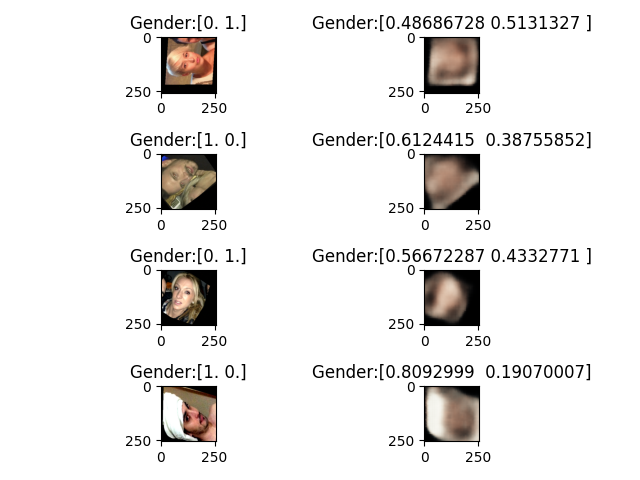

In [45]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [46]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [47]:
outTest = model(xTest)

In [48]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.28837938e+01, 1.06410103e+01, 1.70407181e+01],
          [1.33266830e+01, 1.13246231e+01, 1.32152729e+01],
          [8.73688602e+00, 1.03049402e+01, 8.29692364e+00],
          ...,
          [6.63049221e-01, 4.59585339e-01, 6.29420996e-01],
          [9.11669850e-01, 8.35400343e-01, 8.03611279e-01],
          [4.51943970e+00, 4.54676008e+00, 4.51151323e+00]],
 
         [[1.34209328e+01, 9.11162186e+00, 7.00447559e+00],
          [9.17063332e+00, 5.98783255e+00, 6.23912859e+00],
          [4.91138840e+00, 3.56835818e+00, 3.16808009e+00],
          ...,
          [3.03292125e-01, 9.44553316e-02, 1.79859549e-01],
          [3.87526006e-01, 2.14179307e-01, 2.39136368e-01],
          [1.99856353e+00, 1.14595008e+00, 1.38504851e+00]],
 
         [[9.33534622e+00, 1.10164146e+01, 9.86726475e+00],
          [6.70819044e+00, 3.99933863e+00, 6.15661192e+00],
          [4.71067572e+00, 3.49310684e+00, 4.80915117e+0

<IPython.core.display.Javascript object>


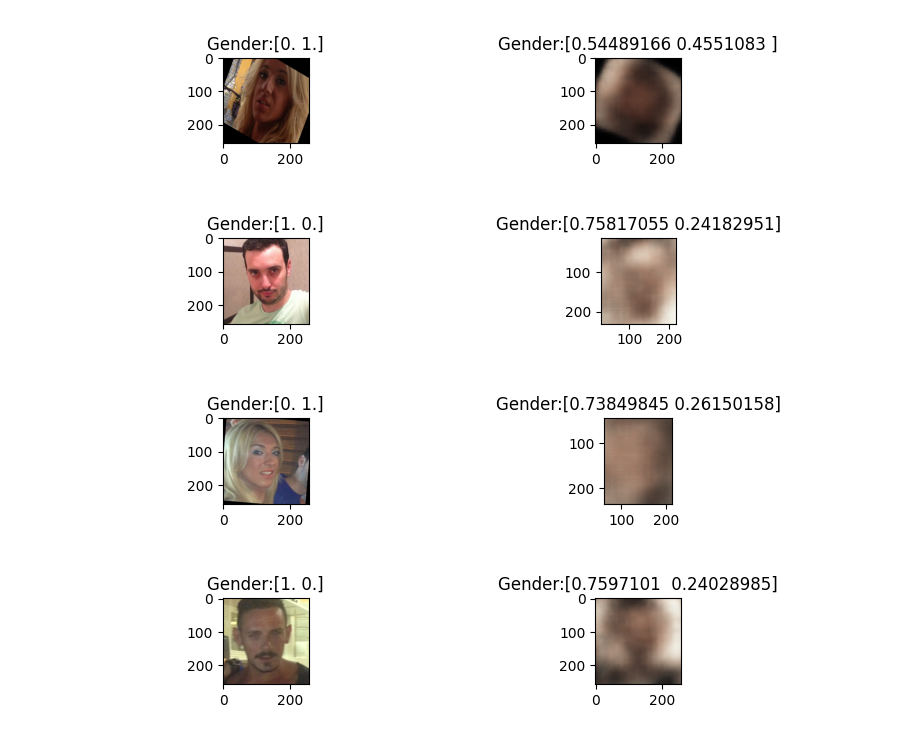

In [49]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()